In [64]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy import stats

urlTrain  = 'https://raw.githubusercontent.com/CyberJuan55/Proyecto-IA/master/DataSet/SpotifyFeatures_train.csv'
urlFull = 'https://raw.githubusercontent.com/CyberJuan55/Proyecto-IA/master/DataSet/SpotifyFeatures.csv'
# el train que nos dieron los profes
#df_train_original= pd.read_csv('/content/SpotifyFeatures_train.csv')
df_train_original = pd.read_csv(urlTrain)
df_train = df_train_original.copy()
# el dataset nuestro
df_full_original = pd.read_csv(urlFull)
df_full = df_full_original.copy()


### Preprocesado de datos y visualizacion 

In [65]:
# Funcion para el preprocesamiento de datos
def preprocesado(df,out=False):

   
    if df.duplicated().sum() == 0:
        print('no hay datos duplicados')
    else:
        df.drop_duplicates
    if 'Unnamed: 0' in df.columns:
        df = df.drop(['Unnamed: 0'], axis=1)

    #df_train = df.drop(['Unnamed: 0'], axis=1)
    df = df.drop(['time_signature','track_id','artist_name','track_name',], axis=1)
    df['genre']= df['genre'].replace(["Children’s Music"],"Children's Music")
    indexNamesChildren = df[ df['genre'] == "Children's Music" ].index
    df.drop(indexNamesChildren , inplace=True)

 

    indexPOP = df[df.popularity==0].index
    df.drop(indexPOP , inplace=True)

    #indexACO = df[df.acousticness < 0.02] .index
    #df.drop(indexACO , inplace=True)
    #indexACO1 = df[df.acousticness > 0.98] .index
    #df.drop(indexACO1 , inplace=True)

    #indexVAL = df[df.valence < 0.08] .index
    #df.drop(indexVAL , inplace=True)
    #indexVAL1 = df[df.valence > 0.9] .index
    #df.drop(indexVAL1 , inplace=True)


    cols_with_missing = [col for col in df.columns if df[col].isnull().any()] 
    faltanDatos = True
    if len(cols_with_missing)==0:
        faltanDatos= False
        print('no faltan valores') 
    if faltanDatos == True:
        print(cols_with_missing)
        df.dropna(axis=0, inplace=True)

    if out == True:
        labelencoder = LabelEncoder()
        df["genre"] = labelencoder.fit_transform(df["genre"])

        df_train_genres = df
        generos=list(df_train['genre'].unique())

        b = []
        for i in generos:
            df=df_train_genres[df_train_genres["genre"]==i].drop(columns=["genre","mode","key"])
     
            z = np.abs(stats.zscore(df))
            #print(np.where(z > 3))
            a=np.where(z > 3)
            outliers=list(set(list(a[0])))
            ñ = [df.iloc[x,:].name for x in outliers]
            b = ñ + b
        df_train_genres.drop(b, axis = 0, inplace = True)

        df = df_train_genres



    X = df.drop(columns=['genre'])
    y = df['genre']
    

    return X,y 


In [66]:
df_train,y = preprocesado(df_train,out=False)

no hay datos duplicados
no faltan valores


In [67]:
df_train

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,6,0.89900,0.147,131787,0.016,0.947000,B,0.0889,-24.317,Major,0.0380,137.591,0.0292
1,27,0.00613,0.857,255134,0.599,0.000085,B,0.2090,-5.677,Major,0.0951,96.022,0.5860
2,59,0.27400,0.518,234905,0.545,0.000023,A#,0.1830,-7.893,Major,0.0385,75.060,0.1620
3,53,0.59400,0.540,213733,0.615,0.803000,A#,0.1200,-9.264,Major,0.0340,93.170,0.2390
4,8,0.95500,0.363,170240,0.196,0.000115,C#,0.6840,-15.675,Minor,0.0452,63.186,0.2510
...,...,...,...,...,...,...,...,...,...,...,...,...,...
186175,42,0.76100,0.464,426560,0.973,0.000000,D#,0.9150,-4.986,Minor,0.9340,79.643,0.2050
186176,30,0.02240,0.698,238185,0.608,0.018900,B,0.1030,-5.307,Minor,0.1370,75.118,0.5960
186177,72,0.00190,0.607,325502,0.813,0.000880,E,0.3050,-5.825,Minor,0.0936,133.962,0.1950
186178,63,0.22600,0.664,254147,0.351,0.000002,C,0.1060,-12.136,Major,0.1180,113.204,0.8160


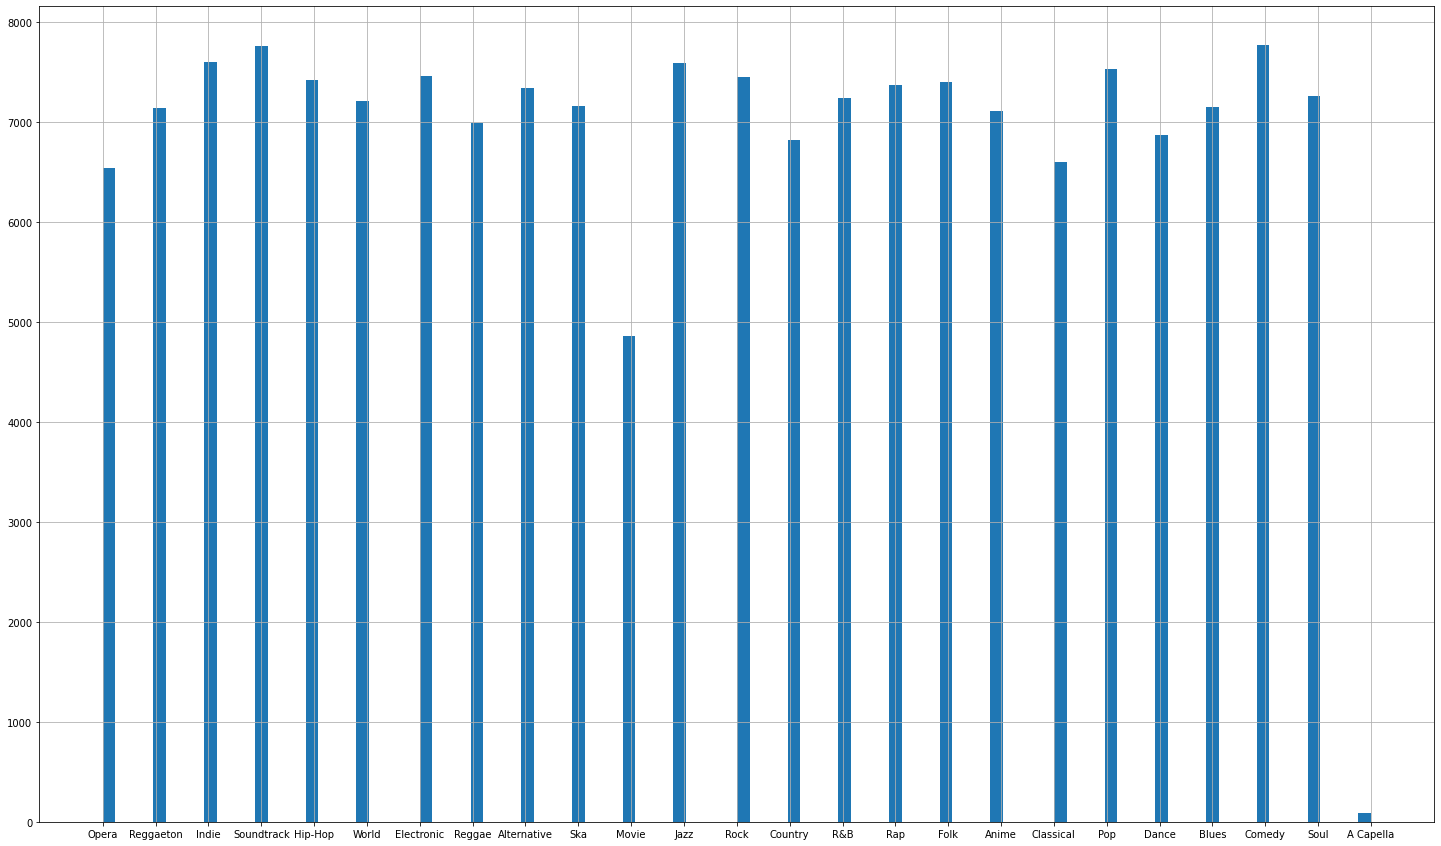

In [27]:
y.hist(bins=100, figsize=(25,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6284f764d0>,
      dtype=object)

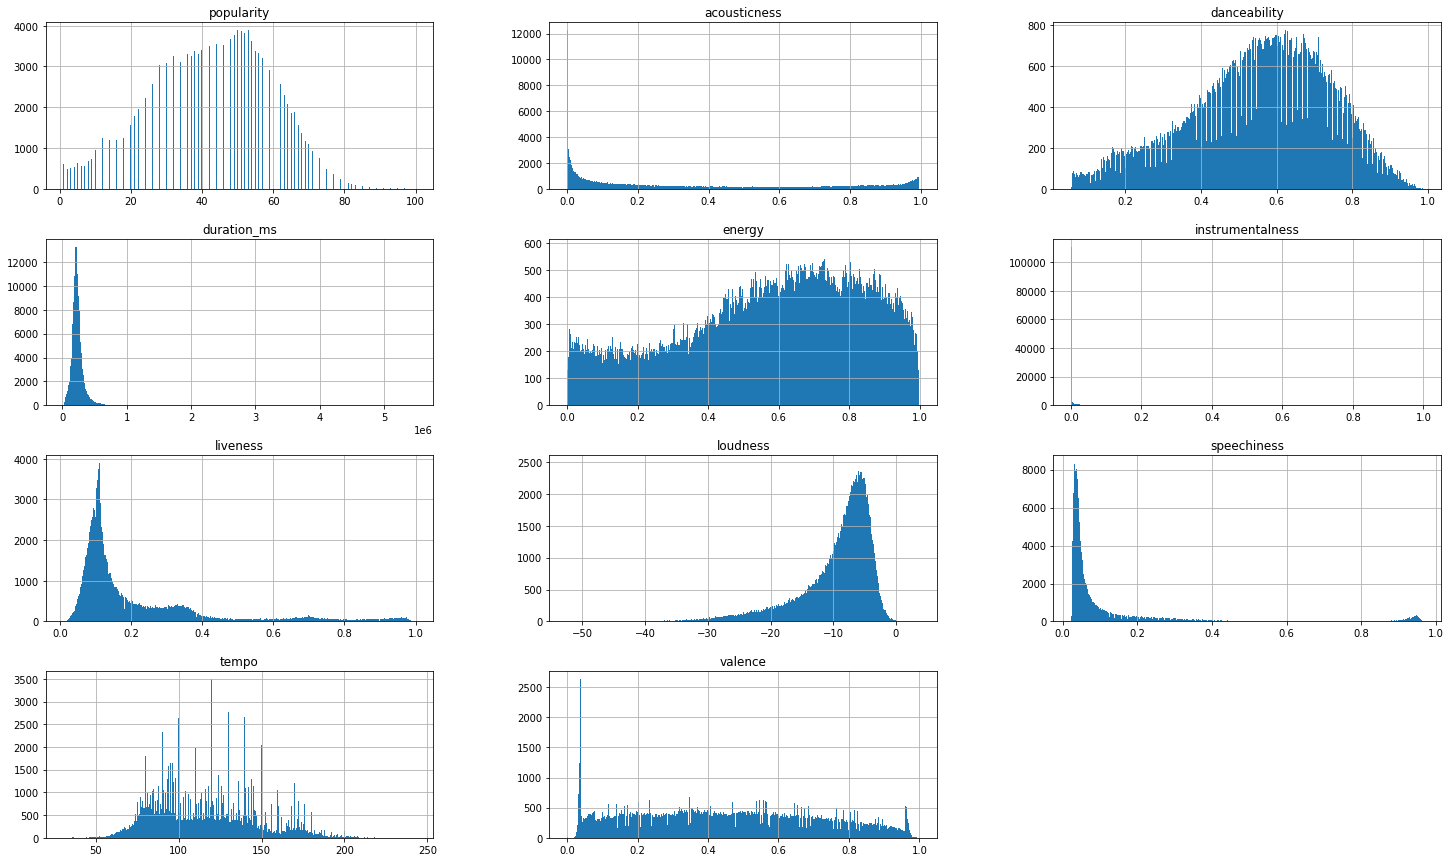

In [29]:
df_train.hist(bins=500, figsize=(25,15))

In [68]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
X_train_full, X_valid_full, y_train, y_valid = train_test_split(df_train, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=42)

In [69]:
df_train_num = df_train.drop(['mode',"key"], axis=1) 

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
        ('standar_scaler', StandardScaler()),
    ])
cat_attribs1 = ["key"]
cat_attribs2 = ["mode"]
num_attribs = list(df_train_num)

full_pipeline = ColumnTransformer([
        ('numerical', num_pipeline, num_attribs),                          
        ("cat", OneHotEncoder(), cat_attribs1),
        ("cat1", OrdinalEncoder(), cat_attribs2)
    ])

In [72]:
df_train_processed = full_pipeline.fit_transform(df_train)

##PCA

In [73]:
a = pd.DataFrame(df_train_processed)

In [74]:
a

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,-2.138163,1.506655,-2.181808,-0.912703,-2.125685,2.599689,-0.636125,-2.453813,-0.446918,0.651549,-1.622876,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.894116,-1.020174,1.635540,0.158094,0.097920,-0.495126,-0.039589,0.644526,-0.144701,-0.692633,0.523792,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.001575,-0.262100,-0.187109,-0.017518,-0.108040,-0.495329,-0.168731,0.276183,-0.444272,-1.370464,-1.110883,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.646133,0.643502,-0.068825,-0.201316,0.158946,2.129052,-0.481652,0.048295,-0.468089,-0.784856,-0.814020,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-2.019682,1.665135,-1.020474,-0.578886,-1.439152,-0.495029,2.319734,-1.017340,-0.408810,-1.754423,-0.767756,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171669,-0.005511,1.116114,-0.477443,1.646272,1.524384,-0.495405,3.467110,0.759384,4.295400,-1.222267,-0.945102,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
171670,-0.716395,-0.974130,0.780669,0.010956,0.132247,-0.433634,-0.566091,0.706028,0.077066,-1.368588,0.562346,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
171671,1.771699,-1.032145,0.291403,0.768970,0.914132,-0.492529,0.437243,0.619926,-0.152640,0.534201,-0.983656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
171672,1.238536,-0.397940,0.597866,0.149525,-0.847970,-0.495397,-0.551190,-0.429088,-0.023497,-0.137033,1.410527,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f627fd02d10>,
      dtype=object)

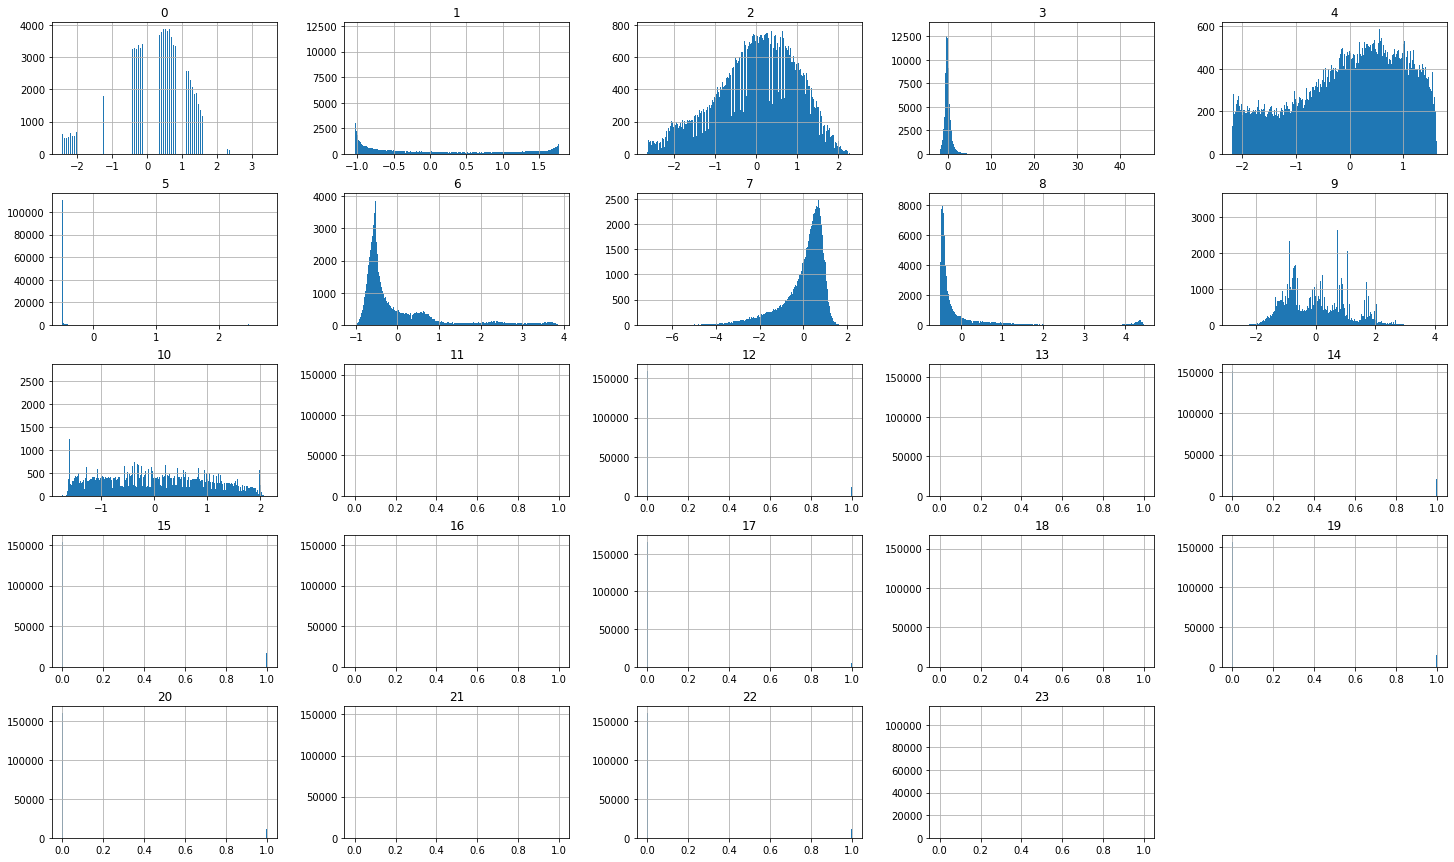

In [75]:
a.hist(bins=500, figsize=(25,15))

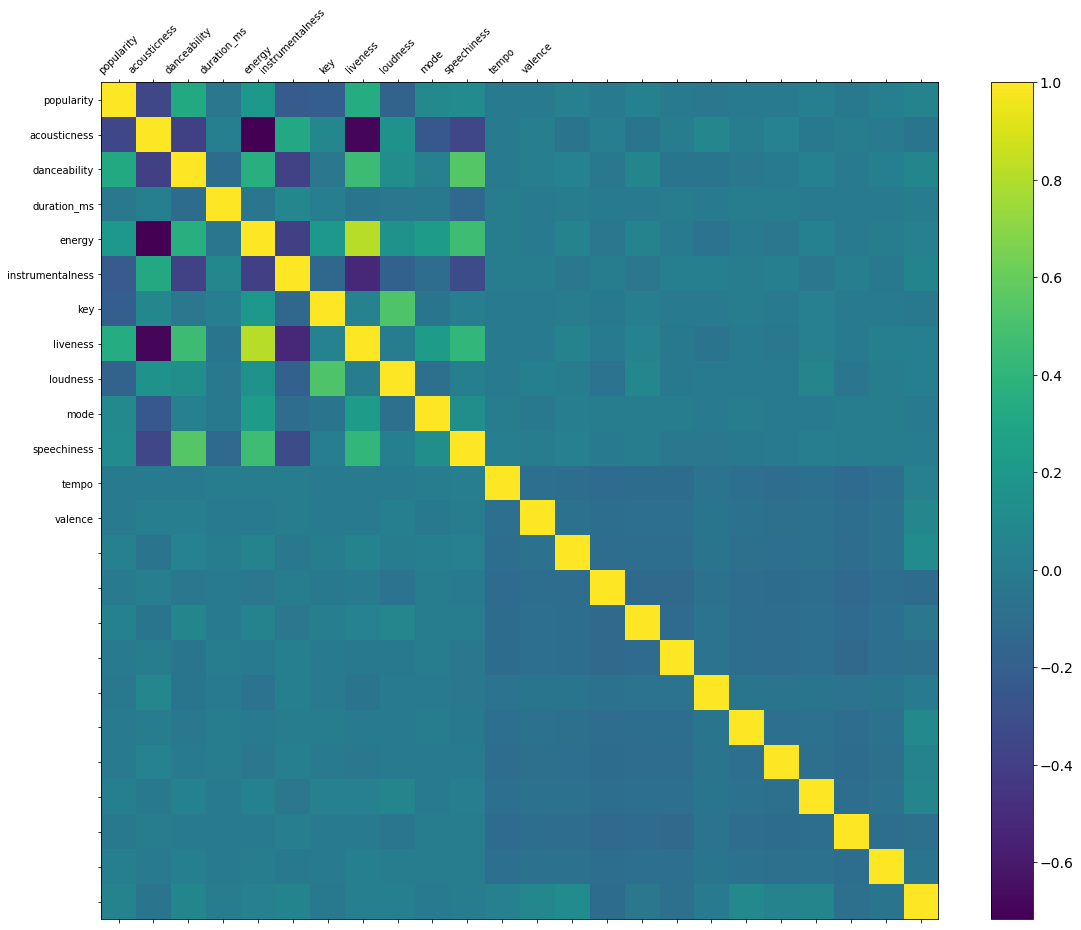

In [76]:
f = plt.figure(figsize=[19,15])
plt.matshow(a.corr(),fignum=f.number)
plt.xticks(range(a.shape[1]),df_train.columns,rotation=45)
plt.yticks(range(a.shape[1]),df_train.columns)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [77]:
from sklearn.decomposition import PCA
dim=[]
var=[]
for comp in range(3, df_train_processed.shape[1]):
    dim.append(comp)
    pca = PCA(n_components= comp, random_state=42)
    pca.fit(df_train_processed)
    comp_check = pca.explained_variance_ratio_
    var.append(sum(comp_check))
    final_comp = comp
    if comp_check.sum() > 0.99:
        break

In [78]:
from sklearn.decomposition import PCA
pca = PCA()
#n_components= 9, random_state=42

In [79]:
pca.fit(a)


PCA()

In [80]:
x_pca = pca.transform(a)

In [81]:
print(x_pca.shape)
print(x_pca)

(171674, 24)
[[ 5.19982771e+00 -6.20987979e-01  4.90561075e-01 ... -1.33638872e-01
  -7.92543387e-02  3.68344256e-16]
 [-1.34064445e+00  2.34074204e-01 -6.64638067e-01 ... -1.31095373e-01
  -2.71383772e-02  2.57321953e-16]
 [ 9.00446316e-02 -5.32148895e-01 -4.00642079e-01 ... -2.29991310e-01
  -5.23578583e-02 -1.59011681e-16]
 ...
 [-1.50511420e+00 -5.04721817e-01  1.13419807e+00 ... -2.52235512e-02
  -1.88501163e-02  1.15491019e-16]
 [-6.65840253e-01 -7.49068104e-01 -1.18773412e+00 ... -4.58466887e-03
  -1.39959319e-02 -4.79893783e-17]
 [ 2.45484767e+00 -8.76895761e-01  1.55183874e+00 ...  2.54894081e-02
  -4.65510869e-02  3.09780049e-16]]


Text(0.5, 0, 'Cantidad de componentes principales')

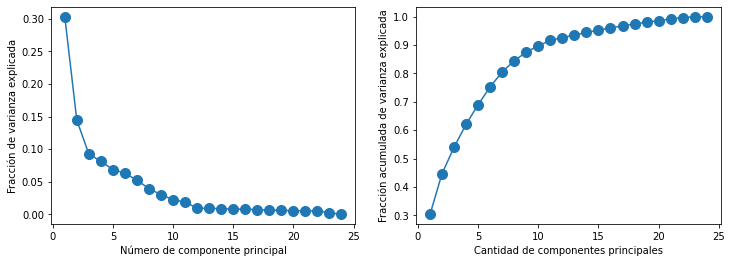

In [82]:
# con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
evr = pca.explained_variance_ratio_

# Graficamos la fracción de varianza que aporta cada componente
# y la información acumulada
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(range(1, len(evr) + 1), evr, '.-', markersize = 20)
ax[0].set_ylabel('Fracción de varianza explicada')
ax[0].set_xlabel('Número de componente principal')

# Calculamos el acumulado con la función cumsum de numpy 
varianza_acumulada = np.cumsum(evr)

ax[1].plot(range(1, len(evr) + 1), varianza_acumulada, '.-', markersize = 20)
ax[1].set_ylabel('Fracción acumulada de varianza explicada')
ax[1].set_xlabel('Cantidad de componentes principales')

In [ ]:
pca = PCA(n_components= 10, random_state=42)


##Modelos

In [83]:
lg=LogisticRegression(max_iter=2000, random_state=1, penalty = 'l2', C = 0.01) #onevsrestclassifier

In [84]:
from sklearn.pipeline import make_pipeline
LGpipe = make_pipeline(full_pipeline,lg)
LGpipe.fit(X_train_full,y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('standar_scaler',
                                                                   StandardScaler())]),
                                                  ['popularity', 'acousticness',
                                                   'danceability',
                                                   'duration_ms', 'energy',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo',
                                                   'valence']),
                                                 ('cat', OneHotEncoder(),
                                                  ['key']),
                                                 ('cat1', OrdinalEncoder(),
       

In [85]:
y_predLG = LGpipe.predict(X_valid_full)

In [86]:
print(accuracy_score(y_valid, y_predLG))

0.3968253968253968


In [ ]:
lg_cross_val = cross_val_score(LGpipe,X_train_full,y_train,cv=5,scoring='accuracy').mean()

In [ ]:
lg_cross_val

0.48673848103557527

In [ ]:
params = {}

params['logisticregression__C'] = [0.1,1,10]


In [ ]:
lGgrid = GridSearchCV(LGpipe, params, cv=5,scoring='accuracy' )
lGgrid.fit(X_train_full,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('standar_scaler',
                                                                                          StandardScaler())]),
                                                                         ['popularity',
                                                                          'acousticness',
                                                                          'danceability',
                                                                          'duration_ms',
                                                                          'energy',
                                                                          'instrumentalness',
                                                                          'liven

In [ ]:
lGgrid.best_score_

0.47883833693727

### DesicionTree

In [ ]:
# Create Decision Tree classifer object
dtc = DecisionTreeClassifier()

dtcPipe = make_pipeline(full_pipeline,dtc)
dtcPipe.fit(X_train_full,y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['popularity', 'acousticness',
                                                   'danceability',
                                                   'duration_ms', 'energy',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo',
                                                   'valence']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['key']),
                                                 ('cat1', OrdinalEncoder(),
                    

In [ ]:
dtc_cross_val = cross_val_score(dtcPipe,X_train_full,y_train,cv=5,scoring='accuracy').mean()

In [ ]:
dtc_cross_val

0.42534350227842843

### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=250, random_state=42)

rfcPipe = make_pipeline(full_pipeline,pca,rfc)
rfcPipe.fit(X_train_full,y_train)




Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('standar_scaler',
                                                                   StandardScaler())]),
                                                  ['popularity', 'acousticness',
                                                   'danceability',
                                                   'duration_ms', 'energy',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo',
                                                   'valence']),
                                                 ('cat1', OrdinalEncoder(),
                                                  ['mode'])])),
                ('pca', PCA(n_components=10, random_state=42)),
             

In [ ]:
predict = rfcPipe.predict(X_valid_full)

In [ ]:
print(accuracy_score(y_valid, predict))

0.5519817590840732


In [ ]:
from sklearn.metrics import roc_auc_score



In [ ]:
rfc_cross_val = cross_val_score(rfcPipe,X_train_full,y_train,cv=5,scoring='accuracy')

In [ ]:
rfc_cross_val

array([0.57264416, 0.56802752, 0.57137684, 0.57409251, 0.56748438])

In [ ]:
predict = rfc.predict(X_valid_full)
print(accuracy_score(y_valid, predict))

###KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 50)
knnPipe = make_pipeline(full_pipeline,pca,knn)
knnPipe.fit(X_train_full, y_train)
#y_pred_knn = knn.predict(X_valid_full)
#print(accuracy_score(y_valid, y_pred_knn))


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('standar_scaler',
                                                                   StandardScaler())]),
                                                  ['popularity', 'acousticness',
                                                   'danceability',
                                                   'duration_ms', 'energy',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo',
                                                   'valence']),
                                                 ('cat1', OrdinalEncoder(),
                                                  ['mode'])])),
                ('pca', PCA(n_components=10, random_state=42)),
             

In [ ]:
y_pred_knn = knnPipe.predict(X_valid_full)
print(accuracy_score(y_valid, y_pred_knn))


0.5432494057148402


In [ ]:
# Numero de arboles
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 8)]
# Numero de features considerado al dividir
max_features = ['auto', 'sqrt']
# numero maximo de niveles
#max_depth = [2,4]
# Numero minimo de niveles por nodo
min_samples_split = [2, 5]
# Numero minimo de niveles por hoja
min_samples_leaf = [1, 2]
# metodo de seleccion por arbol 
bootstrap = [True, False]

### GridSerchCv RandonForest

In [ ]:
#'randomforestclassifier__n_jobs': None
#'randomforestclassifier__n_estimators': 30,
params = {}

params['logisticregression__C'] = [0.1,1,10]


# Grilla
param_grid = {}
param_grid['randomforestclassifier__n_estimators'] = n_estimators
param_grid['randomforestclassifier__max_features'] = max_features
#param_grid['randomforestclassifier__max_depth'] = max_depth
param_grid['randomforestclassifier__min_samples_split'] = min_samples_split
#param_grid['randomforestclassifier__min_samples_leaf'] = min_samples_leaf = [1, 2]
param_grid['randomforestclassifier__bootstrap']  = bootstrap
          
          
               #'bootstrap': bootstrap

In [ ]:
from sklearn.model_selection import GridSearchCV
rfc_Grid = GridSearchCV(estimator = rfcPipe, param_grid = param_grid, cv = 5, scoring='accuracy')
#, verbose=2, n_jobs = 4

In [ ]:
rfc_Grid.fit(X_train_full, y_train)


In [ ]:
rfcPipe.get_params()

In [ ]:
rfc_Grid.best_score_

0.5035514165119226

In [ ]:

from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=250,
     max_depth=5, random_state=0)

In [ ]:
XGBpipe = make_pipeline(full_pipeline,pca, clf)
XGBpipe.fit(X_train_full,y_train)

In [ ]:
XGboost_cross_val = cross_val_score(XGBpipe,X_train_full,y_train,cv=5,scoring='accuracy')

In [ ]:
XGboost_cross_val

array([0.56015208, 0.56531185, 0.56078573, 0.55897529, 0.55562596])

In [ ]:
from sklearn.metrics import roc_auc_score